In [227]:
import pandas as pd
import numpy as np

In [228]:
df = pd.read_excel(r'/Users/shishiragrawal/Downloads/data1.xlsx')

In [229]:
training1 = df[df['Date'] <= '12/31/2002']
training1 = training1.reset_index(drop=True)
dates1 = training1['Date']
del training1['Date']

In [230]:
test = df[df['Date'] > '12/31/02']
test = test.reset_index(drop=True)
dates_test = test['Date']
del test['Date']

In [231]:
dataf = []
for columnName, columnData in training1.iteritems():
    dataf.append(columnData)

In [232]:
def Stacking(toBeStacked,p):
    n=p+1
    stackedF=pd.DataFrame()
    temp=np.zeros(shape=(1,n))
    for cnum in range(toBeStacked.shape[1]):
        temp1=np.zeros(shape=(1,n))
        for rnum in range(n,len(toBeStacked)+1):
            temp1=np.append(temp1,[np.flip(np.array(toBeStacked.iloc[rnum-n:rnum,cnum]))],axis=0)
        temp1=np.delete(temp1,(0),axis=0)
        temp=np.append(temp,temp1,axis=0)
    return(pd.DataFrame(np.delete(temp,(0),axis=0)))

In [233]:
df = Stacking(training1, 90)

In [234]:
df.shape

(116940, 91)

In [235]:
finalDataframe = pd.DataFrame()
for i in range(0,29):
    dummyframes = pd.DataFrame(data = 0, index=range(3898),columns=range(28))
    dummyframes.insert(i, "DV"+str(i), 1)
    finalDataframe = finalDataframe.append(dummyframes)

In [236]:
dvAllZero = pd.DataFrame(data = 0, index=range(3898),columns=range(28))

In [237]:
finalDataframe = finalDataframe.append(dvAllZero, ignore_index=True)

In [238]:
finalDataframe.drop(finalDataframe.iloc[:, 0:28], inplace = True, axis = 1) 

In [239]:
finalDataframe = finalDataframe.fillna(0)

In [240]:
horizontalStack = pd.concat([df, finalDataframe], axis=1)

In [241]:
X = horizontalStack.iloc[:,1:119].values.astype(float)
y = horizontalStack.iloc[:,0].values.astype(float)

In [242]:
testData = Stacking(test, 90)

In [243]:
finalDataframe = pd.DataFrame()
for i in range(0,29):
    dummyframes = pd.DataFrame(data = 0, index=range(1443),columns=range(28))
    dummyframes.insert(i, "DV"+str(i), 1)
    finalDataframe = finalDataframe.append(dummyframes)
dvAllZero = pd.DataFrame(data = 0, index=range(1443),columns=range(28))
finalDataframe = finalDataframe.append(dvAllZero, ignore_index=True)
finalDataframe.drop(finalDataframe.iloc[:, 0:28], inplace = True, axis = 1)
finalDataframe = finalDataframe.fillna(0)
testHorizontalStack = pd.concat([testData, finalDataframe], axis=1)

In [245]:
# Support Vector Regression
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=tscv)
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

In [246]:
svc_param_selection(X,y)

{'C': 0.1, 'gamma': 1}

In [247]:
regressor = SVR(kernel='rbf',gamma=1.0,C=0.1)
regressor.fit(X,y)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [248]:
X2 = testHorizontalStack.iloc[:,1:119].values.astype(float)

In [249]:
svm_pred = regressor.predict(X2)

In [250]:
#random forest

from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators =5, random_state = 0) 
regressor.fit(X,y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [251]:
rf_pred = regressor.predict(X2)

In [255]:
#Boosting
from sklearn.ensemble import GradientBoostingRegressor
tscv = TimeSeriesSplit(n_splits=2)
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200),'n_estimators':range(20,81,100)}

gsearch =GridSearchCV(GradientBoostingRegressor(learning_rate=0.1,warm_start=True), param_grid=param_test, cv=tscv)
gsearch.fit(X,y)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 13, 'min_samples_split': 200, 'n_estimators': 20},
 0.015864825419892148)

In [257]:
Gbre=GradientBoostingRegressor(learning_rate=0.1,n_estimators=20, max_depth=13, warm_start=True)
Gbre.fit(X,y)
gbre_pred = Gbre.predict(X2)

In [258]:
Y2 = testHorizontalStack.iloc[:,0].values.astype(float)

In [259]:
from sklearn.metrics import mean_squared_error

mse_scr = mean_squared_error(Y2, svm_pred)

In [260]:
mse_rf = mean_squared_error(Y2, rf_pred)

In [261]:
mse_gbre = mean_squared_error(Y2, gbre_pred)

In [262]:
print(mse_scr,mse_rf,mse_gbre)

(0.0006850954521405416, 0.0005884870830034478, 0.0005008503530253665)


In [263]:
vec=gbre_pred
vecdf=[]
for i in range(0,1443):
    temp=vec[::1443,]
    vecdf.append(temp)
    vec=np.delete(vec,0)
vec_df_results=pd.DataFrame(vecdf)

In [264]:
rf_pred

array([ 0.01822509, -0.00163188,  0.01227483, ..., -0.00912399,
        0.0134445 , -0.00117275])

In [265]:
vec=Y2
vecdf=[]
for i in range(0,1443):
    temp=vec[::1443,]
    vecdf.append(temp)
    vec=np.delete(vec,0)
vec_df_true=pd.DataFrame(vecdf)

In [266]:
vec_df_results.columns=test.columns.values

In [267]:
vec_df_true.columns=test.columns.values

In [268]:
df2 = vec_df_results
nlargest = 5
order = np.argsort(-df2.values, axis=1)[:, :nlargest]
result2 = pd.DataFrame(df2.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=df2.index)

In [269]:
df2 = vec_df_results
nSmallest = 5
order = np.argsort(df2.values, axis=1)[:, :nSmallest]
result3 = pd.DataFrame(df2.columns[order], 
                      columns=['bottom{}'.format(i) for i in range(1, nSmallest+1)],
                      index=df2.index)

In [270]:
resulting=pd.concat([result2,result3], axis=1)
resulting.head(5)

,top1,top2,top3,top4,top5,bottom1,bottom2,bottom3,bottom4,bottom5
0,T,MRK,C,BAC,HPQ,INTC,BA,DIS,AIG,AXP
1,T,MRK,JNJ,PG,AIG,WMT,MCD,AXP,BA,CAT
2,MSFT,BA,AIG,GE,HPQ,INTC,T,IBM,KO,JPM
3,GM,MSFT,CAT,AXP,DIS,AA,INTC,AIG,MCD,VZ
4,AA,T,JNJ,WMT,XOM,DIS,MCD,PG,AIG,BA


In [271]:
pnl=[]
port=1000000
for i in range(0,1443):
    perstock=0.1*port
    max_5=np.exp(np.array(vec_df_true.loc[i,np.array(result2.iloc[i])]))-1
    min_5=np.exp(np.array(vec_df_true.loc[i,np.array(result3.iloc[i])]))-1
    daily_p=0
    daily_p=sum(perstock*max_5)-sum(perstock*min_5)
    port=port+daily_p-daily_p*0.0005
    pnl.append(port)

In [272]:
print('Final portfolio value',port)

('Final portfolio value', 1788319.2473158326)


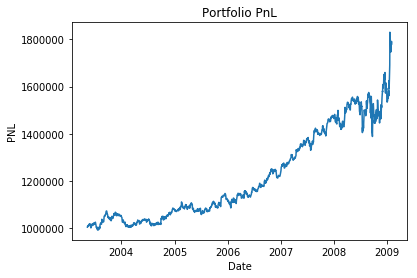

In [273]:
import matplotlib.pyplot as plt
dates_test2=np.delete(np.array(dates_test),range(0,90))
plt.plot(dates_test2,pnl)
plt.title('Portfolio PnL')
plt.ylabel('PNL')
plt.xlabel('Date')
plt.show()

In [274]:
horizontalStack.head()

,0,1,2,3,4,5,6,7,8,9,...,DV26,DV27,DV28,DV3,DV4,DV5,DV6,DV7,DV8,DV9
0,0.011429,0.000000,0.009238,-0.002317,-0.002312,-0.004608,0.039865,0.024214,-0.028988,-0.016529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037909,0.011429,0.000000,0.009238,-0.002317,-0.002312,-0.004608,0.039865,0.024214,-0.028988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.008791,0.037909,0.011429,0.000000,0.009238,-0.002317,-0.002312,-0.004608,0.039865,0.024214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.006645,-0.008791,0.037909,0.011429,0.000000,0.009238,-0.002317,-0.002312,-0.004608,0.039865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015436,-0.006645,-0.008791,0.037909,0.011429,0.000000,0.009238,-0.002317,-0.002312,-0.004608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
horizontalStack.describe()

,0,1,2,3,4,5,6,7,8,9,...,DV26,DV27,DV28,DV3,DV4,DV5,DV6,DV7,DV8,DV9
count,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,...,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000,116940.000000
mean,0.000495,0.000495,0.000492,0.000494,0.000496,0.000499,0.000499,0.000497,0.000499,0.000504,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
std,0.020534,0.020534,0.020534,0.020533,0.020534,0.020534,0.020534,0.020533,0.020534,0.020534,...,0.179506,0.179506,0.179506,0.179506,0.179506,0.179506,0.179506,0.179506,0.179506,0.179506
min,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,-0.379490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.010234,-0.010236,-0.010242,-0.010239,-0.010237,-0.010234,-0.010236,-0.010236,-0.010236,-0.010230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.011234,0.011234,0.011227,0.011228,0.011233,0.011236,0.011236,0.011232,0.011236,0.011236,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.226528,0.226528,0.226528,0.226528,0.226528,0.226528,0.226528,0.226528,0.226528,0.226528,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
